In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from pandas.plotting import scatter_matrix

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, linear, sigmoid
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt



In [105]:
#importing and visualizing training data
train_df = pd.read_csv("train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [106]:
print("shape: ",train_df.shape)
print(train_df.isnull().mean()*100)
print(train_df.isnull().sum())



shape:  (891, 12)
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [107]:
cabin = train_df["Embarked"]
print(cabin.sample(10))
print("unique values:",len(cabin.unique()))


60     C
269    S
890    Q
792    S
424    S
492    S
645    C
740    S
478    S
314    S
Name: Embarked, dtype: object
unique values: 4


In [108]:
#cleaning and processing for training
def process_df(df:pd.DataFrame):
    ohe = OneHotEncoder(categories="auto")
    lb = LabelEncoder()
    imputer = SimpleImputer(strategy="most_frequent")
    
    df = df.drop(columns=["PassengerId","Name","Cabin","Ticket","Age"])

    transformed = np.array(df["Embarked"]).reshape(-1,1)
    df["Embarked"] = pd.DataFrame(imputer.fit_transform(k))
    transformed = ohe.fit_transform(df["Embarked"].values.reshape(-1,1)).toarray()
    df = pd.concat([pd.DataFrame(transformed,columns=np.array(ohe.categories_).ravel()),df],axis=1)
    df = df.drop(columns='Embarked')

    df["Sex"] = pd.DataFrame(lb.fit_transform(df["Sex"].values))

    
    return pd.DataFrame(df)

processed_df = process_df(train_df)
x_df = processed_df.drop(columns=["Survived"])
y_df = processed_df["Survived"]

x_df.head()

,C,Q,S,Pclass,Sex,SibSp,Parch,Fare
0,0.0,0.0,1.0,3,1,1,0,7.2500
1,1.0,0.0,0.0,1,0,1,0,71.2833
2,0.0,0.0,1.0,3,0,0,0,7.9250
3,0.0,0.0,1.0,1,0,1,0,53.1000
4,0.0,0.0,1.0,3,1,0,0,8.0500


In [170]:
#build and train model
model = tf.keras.models.Sequential([

    tf.keras.layers.Dense(units = 20, activation = 'relu'),
    tf.keras.layers.Dense(units = 10, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = 'linear')
])

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [174]:

x_train,x_test, y_train,y_test = train_test_split(x_df,y_df,test_size=0.2)
history = model.fit(x_train,y_train,epochs = 100)

Epoch 1/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4584 - accuracy: 0.7949
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4575 - accuracy: 0.7935
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4578 - accuracy: 0.7992
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 0.4645 - accuracy: 0.7865
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.8062
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4460 - accuracy: 0.8062
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4456 - accuracy: 0.7992
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.8048
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4490 - accuracy: 0.8034
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4432 - accuracy: 0.8020
Epoch 11/

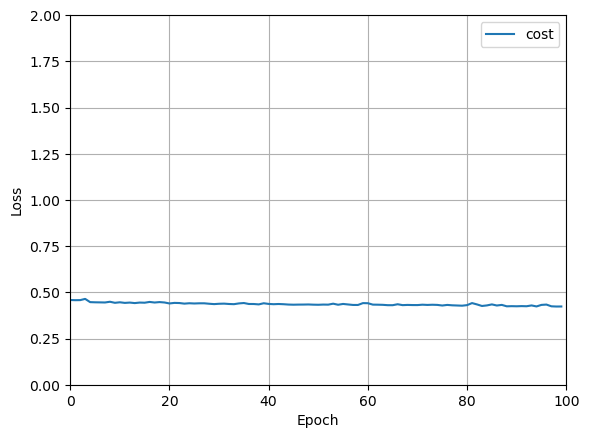

In [175]:
#plotting the costs over epochs
fig, ax =plt.subplots(1,1)
ax.plot(history.history["loss"],label="cost")
ax.set_ylim([0,2])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_xlim([0,100])
ax.legend()
ax.grid(True)

In [176]:
#testing accuracy
def predict_survival(x_predict:pd.DataFrame, model):
    predictions = model.predict(x_predict)
    predictions = 1 /(1+np.exp(-predictions))
    predictions = (predictions>=0.5)*1
    return predictions


test_predictions = predict_survival(x_test,model)
accuracy = np.sum(test_predictions == y_test.values.reshape(-1,1))/len(y_test)*100
print(accuracy)



6/6 [==============================] - 0s 20ms/step
79.88826815642457


In [145]:
#make predictions using test.csv data
given_df = pd.read_csv("test.csv")
export_df = pd.DataFrame()


export_df["PassengerId"] = given_df["PassengerId"]
export_df["Survived"] = predict_survival(process_df(given_df),model)
export_df.head() 

14/14 [==============================] - 0s 1ms/step


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [101]:
#save as csv
export_df.to_csv("submission.csv",index=False)